# Neural Network Regression - Deep Learning
**Name: Aveontae Frazier**

-----------------------------------------------

Thanks to Dr. Dave Wanik for the (mostly) clean data to work with 😃
These are hourly observations of weather vs. energy (electricity) consumption in New England.

Using weather data from the source linked below, I will try to predict energy demand (`Demand`) of New Englanders. *The response variable is measured in measured in megawatt-hours.*

* Here is a link to the energy/weather data: https://drive.google.com/file/d/1q7BJ35j3qDeXfuzmZ93qyeYQLaPgYQc6/view?usp=sharing
    * A data dictionary for the weather data can be found at the bottom of this website: https://mesonet.agron.iastate.edu/request/download.phtml

In [ ]:
# import libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

# Data Processing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Error Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

In [ ]:
!gdown 1VJ3D2Re9Pwp055ihp43n-UPMuMah9RjG

df = pd.read_csv('BDL_cleanweather_energy.csv')

print(f'\nShape of dataset: {df.shape}\n10 random rows:')

df.sample(10)

Downloading...
From: https://drive.google.com/uc?id=1VJ3D2Re9Pwp055ihp43n-UPMuMah9RjG
To: /content/BDL_cleanweather_energy.csv
100% 7.38M/7.38M [00:00<00:00, 12.5MB/s]

Shape of dataset: (96427, 11)
10 random rows:


,Datetime,Demand,BDL_tmpf,BDL_dwpf,BDL_relh,BDL_drct,BDL_sknt,BDL_p01i,BDL_alti,BDL_mslp,BDL_vsby
35820,2017-02-01 14:00:00,3611.659,41.00,19.90,42.44,260.0,16.0,0.0000,29.85,1010.9,10.0
94605,2012-10-17 02:00:00,2333.000,37.04,33.08,85.43,0.0,0.0,0.0000,29.91,1013.0,10.0
96141,2012-12-20 02:00:00,2717.000,30.02,24.08,78.27,270.0,3.0,0.0000,30.12,1019.9,10.0
830,2019-02-04 14:00:00,3185.942,57.00,39.00,50.88,180.0,9.0,0.0000,30.00,1015.7,10.0
39810,2017-07-17 20:00:00,4861.504,75.90,66.90,73.68,190.0,10.0,0.0000,30.08,1018.3,10.0
1415,2019-02-28 23:00:00,3219.356,21.90,5.00,47.56,360.0,5.0,0.0000,30.31,1026.5,10.0
54284,2015-03-13 00:00:00,2977.000,28.04,8.06,42.32,300.0,4.0,0.0000,30.57,1035.2,10.0
95856,2012-12-08 05:00:00,2658.000,39.20,37.94,95.86,350.0,3.0,0.0001,29.96,1014.5,1.5
77270,2021-10-26 18:00:00,3459.060,55.00,54.00,96.42,360.0,16.0,0.0300,29.51,999.1,10.0
73475,2021-05-21 15:00:00,3232.650,82.90,53.10,35.81,190.0,15.0,0.0000,30.38,1028.0,10.0


## Check for missing values and clean data

In [ ]:
df.info() # inspect data types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96427 entries, 0 to 96426
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Datetime  96427 non-null  object 
 1   Demand    96427 non-null  float64
 2   BDL_tmpf  96160 non-null  float64
 3   BDL_dwpf  96160 non-null  float64
 4   BDL_relh  96160 non-null  float64
 5   BDL_drct  96160 non-null  float64
 6   BDL_sknt  96160 non-null  float64
 7   BDL_p01i  96160 non-null  float64
 8   BDL_alti  96160 non-null  float64
 9   BDL_mslp  96160 non-null  float64
 10  BDL_vsby  96160 non-null  float64
dtypes: float64(10), object(1)
memory usage: 8.1+ MB


`Datetime` is an object currently, but I will handle that later.

There appears to be missing values in dataset because `Datetime` and `Demand` have 267 more rows than the rest of the features.

Since there nine columns, if you exclude the two referenced above, this confirms the assertion:

In [ ]:
print(f'Total number of NAs in df: {df.isna().sum().sum():,}\nDividing the total NAs by the number \
of columns prefixed with "BDL_" yields: {df.isna().sum().sum()/9:.0f}')

Total number of NAs in df: 2,403
Dividing the total NAs by the number of columns prefixed with "BDL_" yields: 267


In [ ]:
# drop any rows with missing values (NAs)
df.dropna(axis=0, inplace=True)

In [ ]:
# Check for the number of missing values as 0s
for col in df.columns:
  if col == 'Datetime' or col == 'Demand':
    continue

  print(f'Missing values (0s) in {col}: {np.isclose(df[col], 0).sum():,} or {np.isclose(df[col], 0).sum() / df[col].shape[0] * 100:,.3f}%')

Missing values (0s) in BDL_tmpf: 131 or 0.136%
Missing values (0s) in BDL_dwpf: 1,031 or 1.072%
Missing values (0s) in BDL_relh: 841 or 0.875%
Missing values (0s) in BDL_drct: 9,409 or 9.785%
Missing values (0s) in BDL_sknt: 8,424 or 8.760%
Missing values (0s) in BDL_p01i: 82,025 or 85.301%
Missing values (0s) in BDL_alti: 3 or 0.003%
Missing values (0s) in BDL_mslp: 595 or 0.619%
Missing values (0s) in BDL_vsby: 16 or 0.017%


Based on the number of missing number of values in `BDL_p01i`, I will remove the attribute.

In [ ]:
# Drop BDL_p01i
df.drop(columns=['BDL_p01i'], inplace=True)

df.head()

,Datetime,Demand,BDL_tmpf,BDL_dwpf,BDL_relh,BDL_drct,BDL_sknt,BDL_alti,BDL_mslp,BDL_vsby
0,2019-01-01 00:00:00,2713.617,37.9,37.9,100.0,360.0,4.0,29.88,1009.7,5.0
1,2019-01-01 01:00:00,2578.343,37.9,37.9,100.0,360.0,4.0,29.79,1006.3,2.0
2,2019-01-01 02:00:00,2467.969,37.9,37.9,100.0,340.0,7.0,29.70,1003.3,2.0
3,2019-01-01 03:00:00,2397.140,37.9,37.9,100.0,310.0,6.0,29.63,1002.3,1.5
4,2019-01-01 04:00:00,2381.258,37.9,37.9,100.0,140.0,3.0,29.58,1001.2,1.5


## Handle `Datetime`

In [ ]:
df['Datetime'] = pd.to_datetime(df['Datetime'])
df['Datetime'].info() # confirm result

# Extract time elements
df['Hour'] = df['Datetime'].dt.hour
df['Date of Week'] = df['Datetime'].dt.day_of_week
df['Week of Year'] = df['Datetime'].dt.isocalendar().week
df['Quarter'] = df['Datetime'].dt.quarter

df[['Datetime','Hour', 'Date of Week', 'Week of Year', 'Quarter']].sample(5) # review sample rows

<class 'pandas.core.series.Series'>
Index: 96160 entries, 0 to 96426
Series name: Datetime
Non-Null Count  Dtype         
--------------  -----         
96160 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 3.5 MB


,Datetime,Hour,Date of Week,Week of Year,Quarter
44612,2014-02-02 22:00:00,22,6,5,1
74500,2021-07-03 08:00:00,8,5,26,3
84126,2020-08-07 10:00:00,10,4,32,3
25818,2016-12-11 19:00:00,19,6,49,4
32090,2013-08-30 04:00:00,4,4,35,3


In [ ]:
df.drop(columns=['Datetime'], inplace=True) # don't need anymore

df.head()

,Demand,BDL_tmpf,BDL_dwpf,BDL_relh,BDL_drct,BDL_sknt,BDL_alti,BDL_mslp,BDL_vsby,Hour,Date of Week,Week of Year,Quarter
0,2713.617,37.9,37.9,100.0,360.0,4.0,29.88,1009.7,5.0,0,1,1,1
1,2578.343,37.9,37.9,100.0,360.0,4.0,29.79,1006.3,2.0,1,1,1,1
2,2467.969,37.9,37.9,100.0,340.0,7.0,29.70,1003.3,2.0,2,1,1,1
3,2397.140,37.9,37.9,100.0,310.0,6.0,29.63,1002.3,1.5,3,1,1,1
4,2381.258,37.9,37.9,100.0,140.0,3.0,29.58,1001.2,1.5,4,1,1,1


## Split into X and y, then into train and test partitions

In [ ]:
# Split df
X = df.drop(columns=['Demand'])
y = df['Demand']

# Partition data
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=276472) # my student ID

X_train_columns = X_train.columns # save for downstream tasks

print(f"X_train shape: {X_train.shape}\nX_test shape: {X_test.shape}\n\ny_train shape: {y_train.shape}\ny_test shape: {y_test.shape}")

X_train shape: (76928, 12)
X_test shape: (19232, 12)

y_train shape: (76928,)
y_test shape: (19232,)


In [ ]:
X_train.sample(5)

,BDL_tmpf,BDL_dwpf,BDL_relh,BDL_drct,BDL_sknt,BDL_alti,BDL_mslp,BDL_vsby,Hour,Date of Week,Week of Year,Quarter
30846,73.04,69.98,90.14,0.0,0.0,30.08,1018.4,9.0,8,1,28,3
95903,39.92,37.94,92.56,360.0,5.0,29.89,1012.1,3.0,4,0,50,4
86824,48.90,41.00,74.05,300.0,3.0,29.98,1015.3,10.0,20,4,48,4
43373,18.00,7.00,61.52,290.0,14.0,29.39,995.3,10.0,7,2,50,4
85638,54.00,35.10,48.65,340.0,4.0,30.24,1023.7,10.0,10,4,41,4


In [ ]:
y_train.sample(5)

,Demand
17350,3447.000
39972,3549.426
61859,3725.620
20264,2642.013
63348,3076.600


## Basic EDA
Below are a few EDA plots which analyze the distribution of the response (`Demand`) and the remaining attributes in `X_train`.

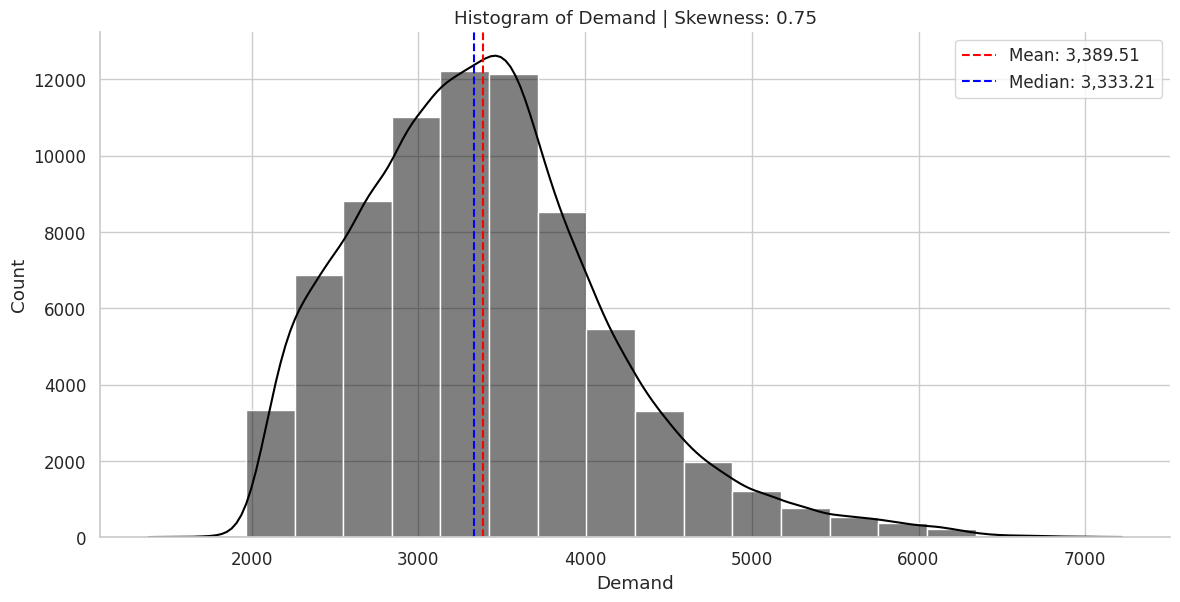

In [ ]:
# Histogram illustrating Demand's distribution
# Set the display settings
sns.set(style="whitegrid", palette="colorblind", font_scale=1.1)
sns.displot(y_train, kde=True, bins=20, color="black", height= 6, aspect=2)

plt.title(f"Histogram of Demand | Skewness: {round(df['Demand'].skew(),2)}") # include skew
plt.xlabel("Demand")

# Extract the mean and median of y_train
demand_mean = y_train.mean()
demand_median = y_train.median()

# add lines that indicate where the mean and median fall
plt.axvline(demand_mean, color="red", linestyle="--", label=f"Mean: {demand_mean:,.2f}")
plt.axvline(demand_median, color="blue", linestyle="--", label=f"Median: {demand_median:,.2f}")

plt.legend()
plt.show()

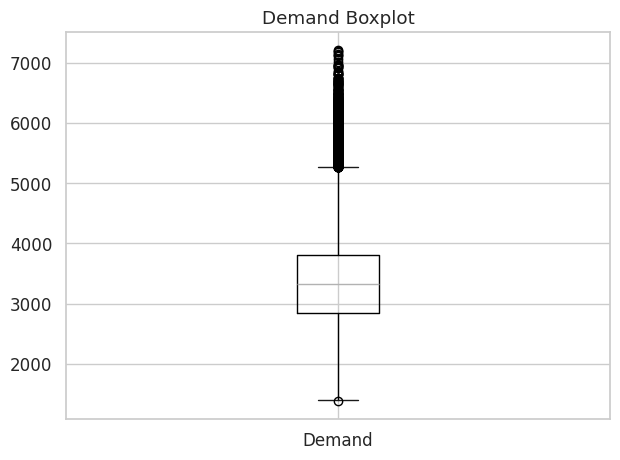

In [ ]:
# Bloxplot of Demand
pd.DataFrame(y_train).boxplot() # inspect outliers
plt.title("Demand Boxplot")
plt.tight_layout()
plt.show()

In [ ]:
y_train.std()

762.0499559982815

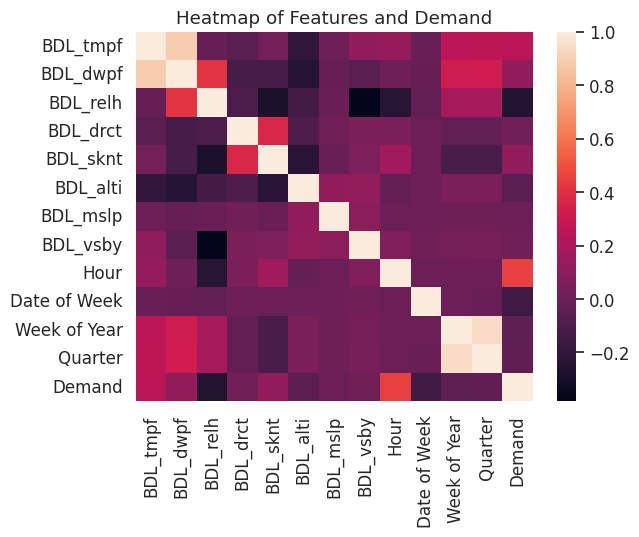

In [ ]:
# Check correlation of attributes with the response
corr = X_train.join(y_train).corr()
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values
)

plt.title("Heatmap of Features and Demand")

plt.show()

Interestingly, `Hour` appears to have the highest correlation to `Demand`. I want to see a bivariate plot of `Demand` and the attributes in `X_train`.

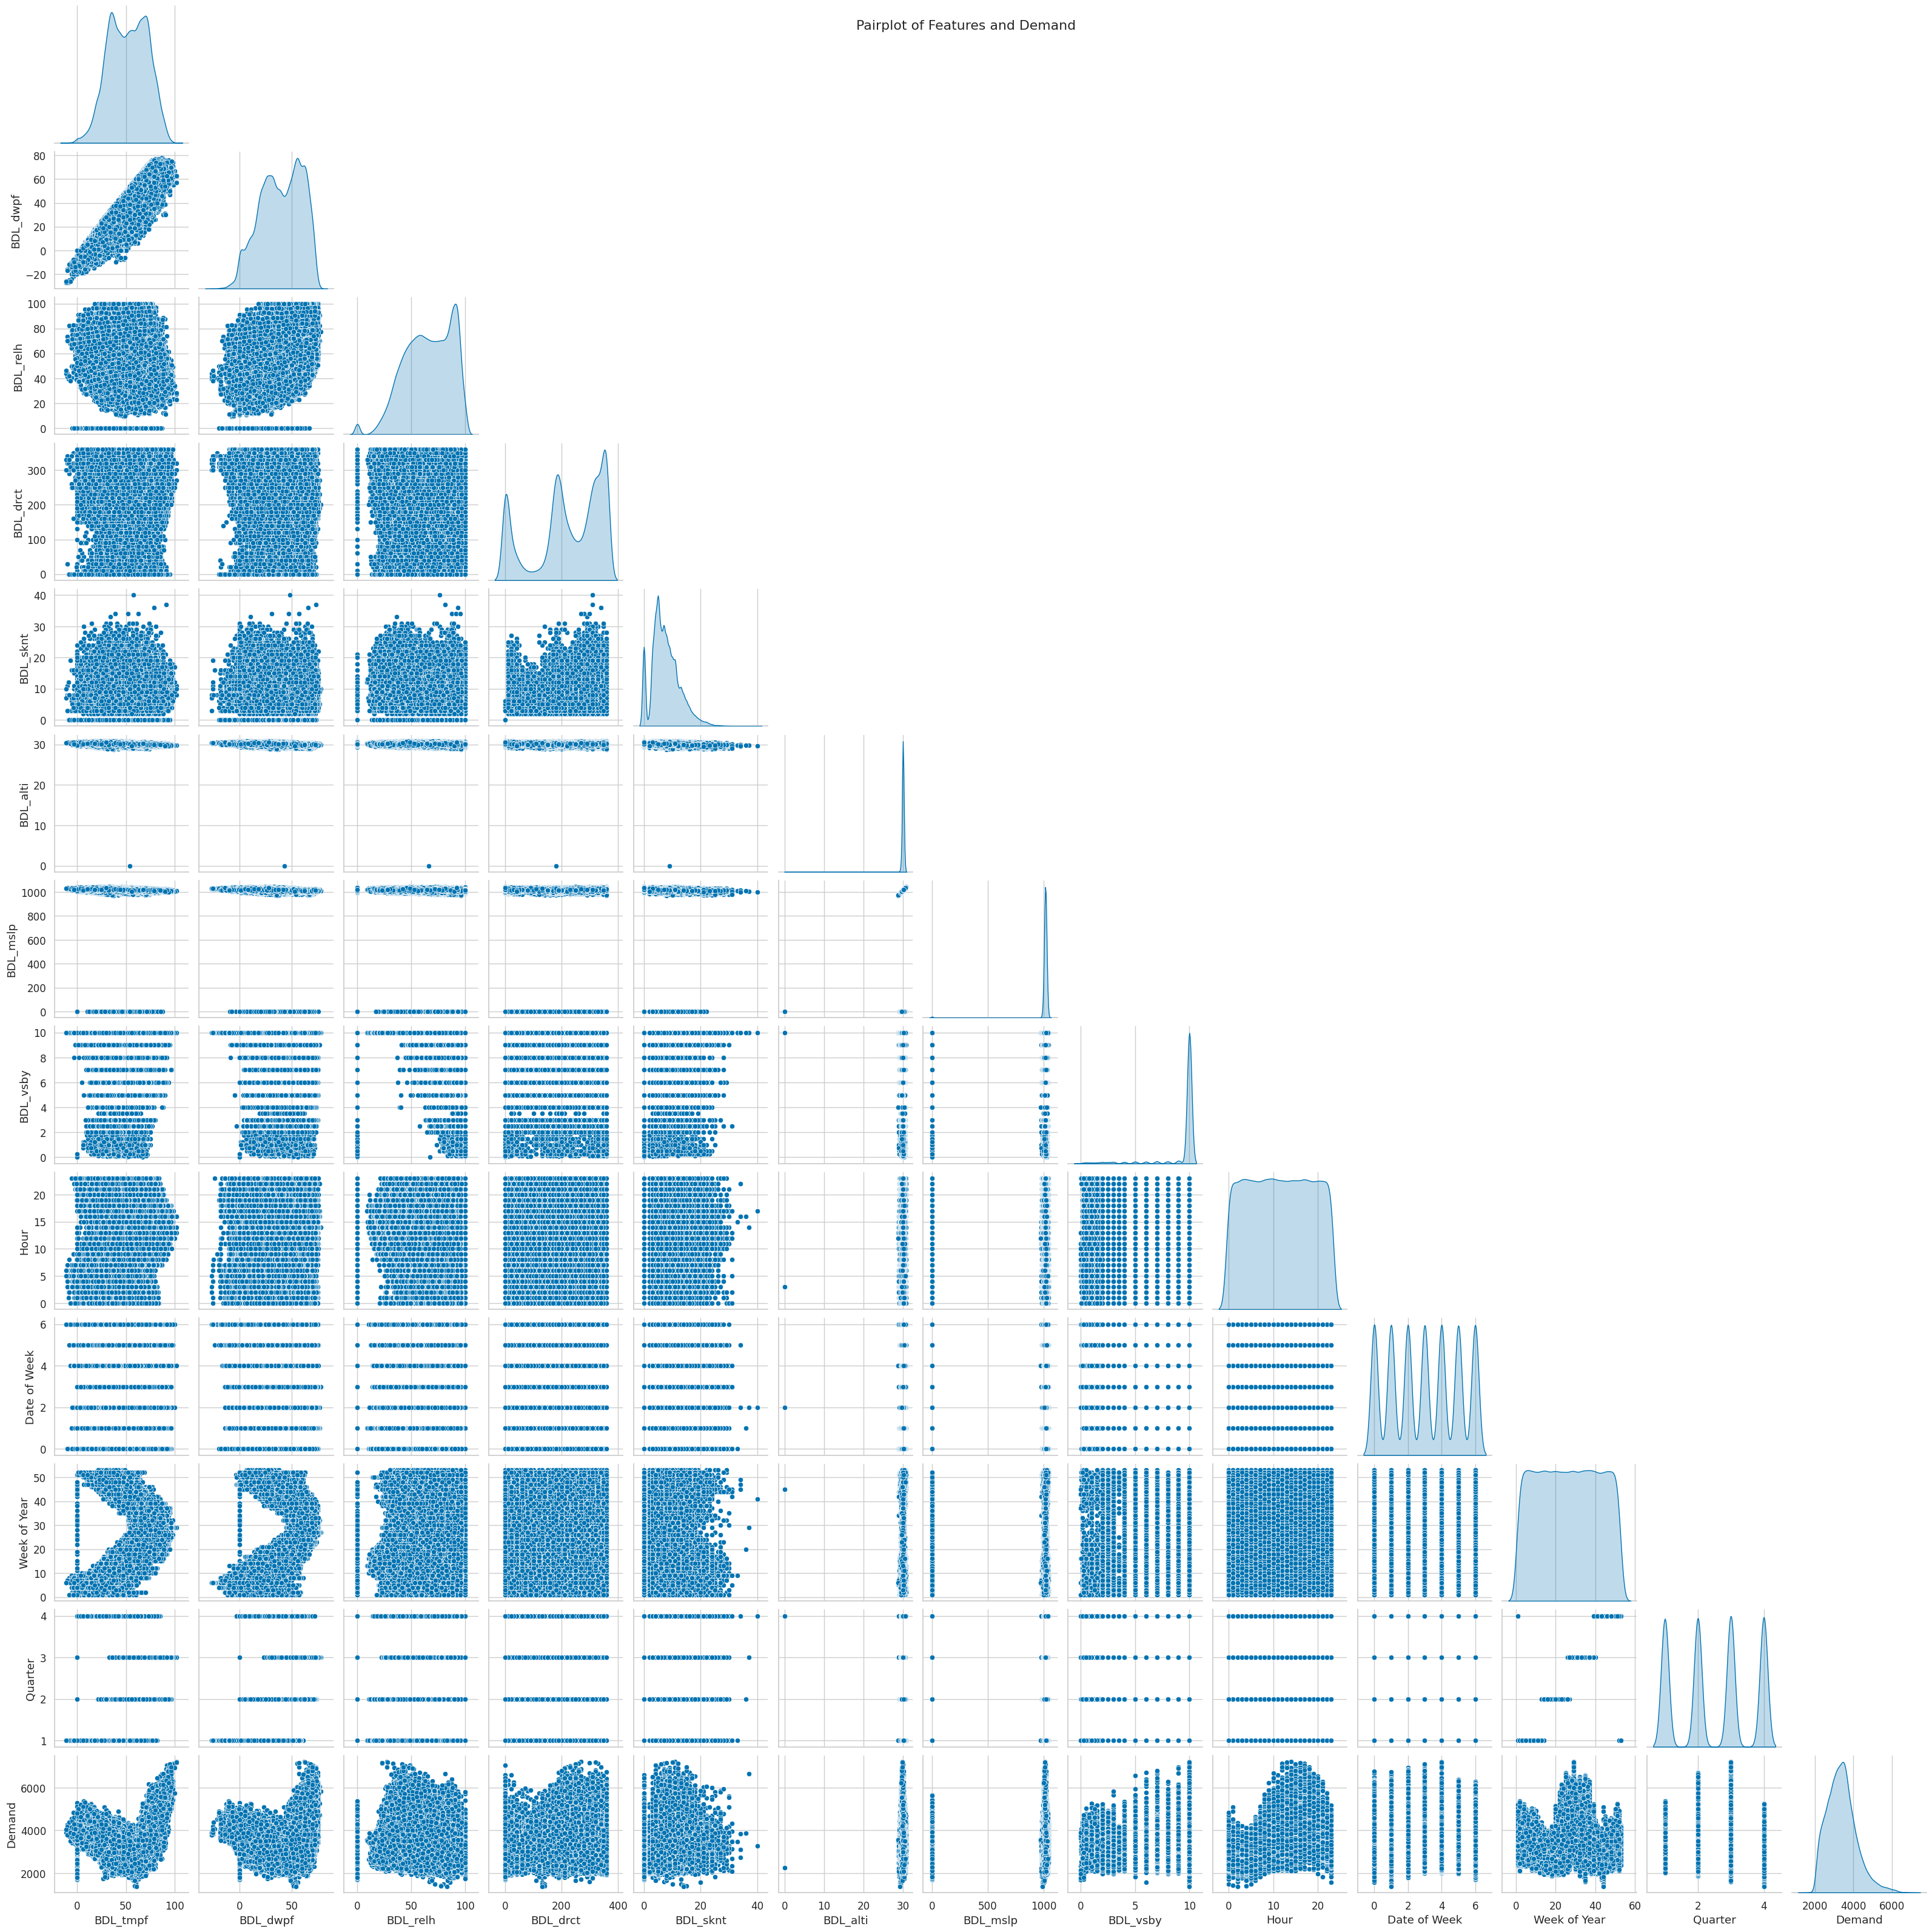

In [ ]:
# Pairplot
sns.pairplot(X_train.join(y_train), diag_kind='kde', corner=True)
plt.suptitle("Pairplot of Features and Demand")
plt.show()

Woah! The relationship between `Hour` and `Demand` is definitely not simple, and their scatterplot illustrates strong nonlinearity. What is observed suggests a cyclical pattern, almost like a wave, throughout the day. This will complicate modeling!

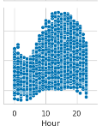

## Data preprocessing

In [ ]:
# Define scaler using MinMax
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train) # fit on train
X_test = scaler.transform(X_test) # transform test

tmp = pd.DataFrame(X_train, columns=X_train_columns) # look at scaled training values
tmp.describe()

,BDL_tmpf,BDL_dwpf,BDL_relh,BDL_drct,BDL_sknt,BDL_alti,BDL_mslp,BDL_vsby,Hour,Date of Week,Week of Year,Quarter
count,76928.000000,76928.000000,76928.000000,76928.000000,76928.000000,76928.000000,76928.000000,76928.000000,76928.000000,76928.000000,76928.000000,76928.000000
mean,0.557327,0.634607,0.655930,0.614784,0.189224,0.973078,0.967044,0.933909,0.499898,0.499476,0.491692,0.502253
std,0.170871,0.187437,0.214166,0.329143,0.119407,0.008450,0.075969,0.198160,0.300499,0.333454,0.289555,0.372119
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.415959,0.494863,0.495100,0.472222,0.100000,0.968233,0.967933,1.000000,0.260870,0.166667,0.250000,0.333333
50%,0.557502,0.647260,0.666500,0.638889,0.175000,0.973096,0.972815,1.000000,0.478261,0.500000,0.500000,0.666667
75%,0.699045,0.789384,0.844400,0.916667,0.250000,0.977958,0.977888,1.000000,0.739130,0.833333,0.750000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Fit, Compile, and run model

In [ ]:
X_train.shape[1] # The number of columns for modeling: 12

12

In [ ]:
# resets names in the model summary
from keras import backend as K
K.clear_session()

In [ ]:
model = Sequential()
model.add(Dense(1000, input_shape=(X_train.shape[1],), activation='relu')) # (features,)
model.add(Dropout(0.20)) # 20% dropout in first three layers
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.20)) # 20% dropout in first three layers
model.add(Dense(250, activation='relu'))
model.add(Dropout(0.20)) # 20% dropout in first three layers
model.add(Dense(125, activation='relu'))
model.add(Dense(60, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(1, activation='linear')) # output node
model.summary() # view the model

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 1000)                │          13,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 500)                 │         500,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 250)                 │         125,250 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 250)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 125)                 │          31,375 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 60)                  │           7,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 30)                  │           1,830 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 15)                  │             465 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              16 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 679,996 (2.59 MB)

 Trainable params: 679,996 (2.59 MB)

 Non-trainable params: 0 (0.00 B)

That's a lot of trainable parameters!

In [ ]:
model.compile(optimizer='adam', # or rsmprop
              loss='mse', # or mae
              metrics=['mae'])

### Callbacks/Early Stopping

In [ ]:
es = EarlyStopping(monitor='val_loss',
                   mode='min', # minimize validation loss
                   patience=100,
                   restore_best_weights=True) # ensure to restore best weights

In [ ]:
# Fit the model
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    callbacks=[es], # early stopping callbacks
                    epochs=5000, # passes through dataset
                    batch_size=100, # num of examples processed before update
                    shuffle=True,
                    verbose=1)

Epoch 1/5000
770/770 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 2160019.2500 - mae: 984.5479 - val_loss: 180410.8906 - val_mae: 333.8667
Epoch 2/5000
770/770 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 210904.9688 - mae: 360.8130 - val_loss: 123402.3047 - val_mae: 277.6432
Epoch 3/5000
770/770 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 171037.3281 - mae: 325.7488 - val_loss: 114128.3750 - val_mae: 265.8930
Epoch 4/5000
770/770 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 156804.3281 - mae: 311.5317 - val_loss: 137885.4219 - val_mae: 292.8571
Epoch 5/5000
770/770 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 143856.9375 - mae: 297.5944 - val_loss: 102724.4766 - val_mae: 249.9343
Epoch 6/5000
770/770 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 141832.4375 - mae: 294.4703 - val_loss: 105652.5859 - val_mae: 254.1317
Epoch 7/5000
770/770 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 135891.2656 - mae: 288.3536 - val_loss: 80514.8984 - val_mae: 221.4261
Epoch 8/5000
770/770 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss:

In [ ]:
history_dict = history.history # containing data about sequence
history_dict.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

## Learning Curves

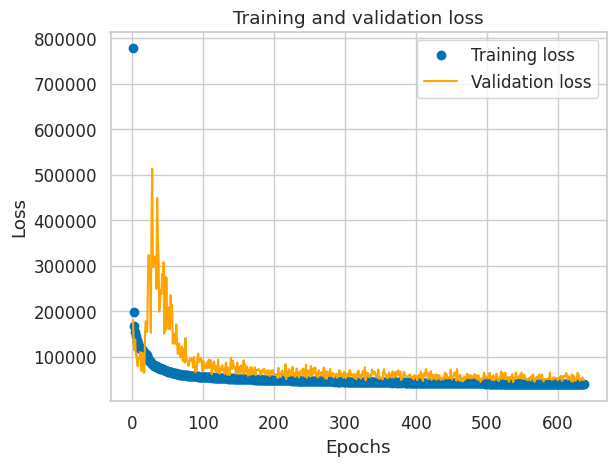

In [ ]:
# Loss
loss_vals = history_dict['loss']
val_loss_vals = history_dict['val_loss']

epochs = range(1, len(loss_vals) + 1) # range of X is to the # of epochs
plt.plot(epochs, loss_vals, 'bo', label='Training loss')
plt.plot(epochs, val_loss_vals, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

This appears to suggest the model converged around 200 or so epochs.

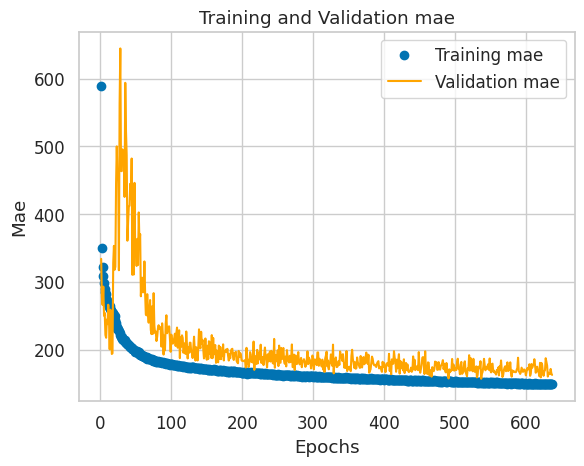

In [ ]:
# mae
loss_vals = history_dict['mae']
val_loss_vals = history_dict['val_mae']

epochs = range(1, len(loss_vals) + 1)
plt.plot(epochs, loss_vals, 'bo', label='Training mae')
plt.plot(epochs, val_loss_vals, 'orange', label='Validation mae')
plt.title('Training and Validation mae')
plt.xlabel('Epochs')
plt.ylabel('Mae')
plt.legend()
plt.show()

The bigger ocsillations with mae are intriguing.

## Generate Model Predictions

In [ ]:
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

2404/2404 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
601/601 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


## Scatterplots of actuals vs. preds

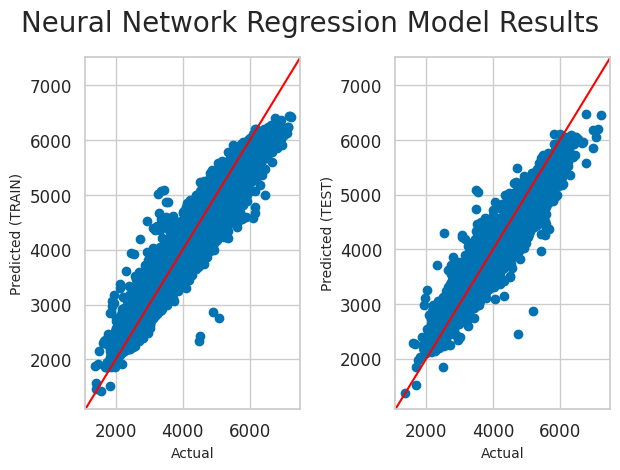

In [ ]:
# Compute limits for plits
train_min = np.min([y_train.min(), train_preds.min()])
train_max = np.max([y_train.max(), train_preds.max()])
train_margin = 0.05 * (train_max - train_min) # 5% margin for better visibility

test_min = np.min([y_test.min(), test_preds.min()])
test_max = np.max([y_test.max(), test_preds.max()])
test_margin = 0.05 * (test_max - test_min) # 5% margin for better visibility

# Specify dimensions
fig, axes = plt.subplots(1, 2) # one row, two columns

fig.suptitle('Neural Network Regression Model Results', fontsize=20)

# Individual train plot
axes[0].scatter(x=y_train, y=train_preds)
axes[0].set_xlabel('Actual', fontsize=10)
axes[0].set_ylabel('Predicted (TRAIN)', fontsize=10)
# Limits
axes[0].set_xlim(train_min - train_margin, train_max + train_margin)
axes[0].set_ylim(train_min - train_margin, train_max + train_margin)
# 45 Degree line
x = np.linspace(*axes[0].get_xlim())
axes[0].plot(x, x, color='red')

# Individual test plot
axes[1].scatter(x=y_test, y=test_preds)
axes[1].set_xlabel('Actual', fontsize=10)
axes[1].set_ylabel('Predicted (TEST)', fontsize=10)
# Limits
axes[1].set_xlim(test_min - test_margin, test_max + test_margin)
axes[1].set_ylim(test_min - test_margin, test_max + test_margin)
# 45 Degree line
x = np.linspace(*axes[1].get_xlim())
axes[1].plot(x, x, color='red')

plt.tight_layout()

fig.subplots_adjust(top=0.88)

plt.show()

## Error Metrics

In [ ]:
# R2
print(f'R2 (Train): {r2_score(y_train, train_preds):,.4f}')
print(f'R2 (Test): {r2_score(y_test, test_preds):,.4f}\n')

# mse
print(f'MSE (Train): {mean_squared_error(y_train, train_preds):,.2f}')
print(f'MSE (Test): {mean_squared_error(y_test, test_preds):,.2f}\n')

# mae
print(f'MAE (Train): {mean_absolute_error(y_train, train_preds):,.2f}')
print(f'MAE (Test): {mean_absolute_error(y_test, test_preds):,.2f}')

R2 (Train): 0.9395
R2 (Test): 0.9236

MSE (Train): 35,137.28
MSE (Test): 44,091.01

MAE (Train): 140.98
MAE (Test): 156.85


# Conclusion

A few bullet points about how my experience went and lessons learned!
____

1.   ***Architecture's importance for capturing nonlinear patterns***: The importance of neural network architecture was highlighted by my initial modeling attempts. To keep things simple on my first run, I used one dense layer—containing 12 hidden units for the 12 input features—that fed into the output layer. I limited the epochs to 100 (arbitrarily selected) and let it run to completion. This yielded a very low $R^2$ on the training and holdout samples (**~.32**), and the MAE (**>500**) and MSE were large. However, once I utlized a more complex architecture—8 total layers with 1,000 hidden units in the input layer, halving with each sequential layer—I achieved significantly improved results!
2.   ***Early Stopping Callbacks***: As I stated in my previous bullet, I severely limited the model's passes over the data with 100 epochs in the first run. After increasing the complexity of the model, my metrics improved, but I hadn't changed the number of epochs. While the training loss appeared to possibly converge, the large oscillations in the validation loss suggested it hadn't. Implementing early stopping with `patience = 10` didn't quite yield my desired result. However, after several attempts, I tried `patience = 100`, and the model ran 637 epochs. My $R^2$ grew and the MAE and MSE were minimized further, indicating the model was optimized better. Looking at the error metrics from the generated predictions, the $R^2$ is about .93 for both partitions and the MAEs have been reduced to under 160.
3.   ***Modeling Art vs. Science***: One takeaway from the initial chapters of the O'Reilly Deep Learning text is that neural network modeling is not exactly a hard science; it doesn't appear the practical modeling process is limited, but rather a combination of best practices and iteration will lead to better performance in the long run. I think this is underscored by the fact that it was difficult to get started with a model archictecture. Since this was my first time, I was a bit lost on where to start, but I decided to simply jump in!
4.   ***CPU vs GPU Performance***: One reason I set the number of epochs low on the initial run was because I was unsure of how long it would take to process the data. Based on the O'Reilly text, I was aware that GPU availability was important for neural networks, though it was technically possble to use a CPU. Thankfully, I have some compute units to test the theory out, and I quickly discovered it's validity, particularly when I implemented the early stopping callback. Even with 637 epochs, the model runs within 25 minutes, but it would likely take longer on a CPU.
5.   ***The Power of Neural Networks***: Looking back to the EDA process, it amazes me that the model learned, with precision, how to predict the response; `Demand` has some large values, some in the thousands, so for the test MAE to be approximately 156 is impressive. The patterns in this data present nonlinear trends that would likely be difficult to model using more traditional regression algorithms such as linear regression, gradient boosting regression, random forest regression, etc. Implementing dropout helped the model learn slower, but I noticed my error metrics significantly diminished. So, instead of adding dropout in each layer, I implemented 20% dropout exclusively for the first three layers.

